In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.optimize import curve_fit
import math
import pandas as pd
from IPython.display import display, HTML

# written by Dongwook (Danny) Lim 
# Date updated: 04/10/2023

In [2]:
# Gaussian function
def gaussian(x, O_p, R_n, R_p, R_0, sigma, sigma2):
    y = R_0 + R_p * np.exp(-((x - O_p) ** 2) / (2 * sigma ** 2)) + R_n * np.exp((-(x - O_p + 180) ** 2) / (2 * sigma2 ** 2))
    return y

def gaussian2(x, O_p_s, R_n_s, R_p_s, R_0_s, sigma_s, sigma2_s):
    y = R_0_s + R_p_s * np.exp(-((x - O_p_s) ** 2) / (2 * sigma_s ** 2)) + R_n_s * np.exp((-(x - O_p_s + 180) ** 2) / (2 * sigma2_s ** 2))
    return y

def OrientationTuning(direc, fps):
    # Load data
    f = np.load(direc + "/F.npy")
    fneu = np.load(direc + "/Fneu.npy")
    iscell = np.load(direc + "/iscell.npy")
    spks = np.load(direc + "/spks.npy")
    zeroC = scipy.io.loadmat(direc + "/zeroCrossings.mat")["zeroCrossings"].flatten()

    # Pre-processing
    cellvalue = f - 0.7 * fneu
    original_ind = np.where(iscell[:, 0] == 1)[0]
    cellFneu = cellvalue[original_ind, :]

    angles = [int(360 / (zeroC.shape[0] / 2 / 8)) * i for i in range(int(zeroC.shape[0] / 2 / 8))]
    orientations = -np.ones(fneu.shape[1])
    orient_dict = dict(zip(angles, [[]] * len(angles)))

    for i in range(len(zeroC) // 2):
        startind = zeroC[i * 2]
        endind = zeroC[i * 2 + 1]
        angle = angles[i % len(angles)]
        orientations[startind:endind] = angle
        orient_dict[angle] = orient_dict[angle] + [(startind, endind)]

    plt.plot(orientations)
    plt.show()
    
    return([f, fneu, iscell, spks, zeroC, cellFneu, original_ind, orient_dict, orientations, angles])



def CelldataProcess(c, activitytrace=True, resultplot=True, OriActiplot=True, DataFitplot=True, SpikeFitplot=True):
    # Grab the target cell
    cell = cellFneu[c, :]
    increment = angles[1]
    print("\n\n\n\n=============================================================================================================")
    print("=============================================================================================================")
    
    # Calculate angle rests
    angle_rests = dict(zip(angles, [[]] * len(angles)))
    angle_spike_rests = dict(zip(angles, [[]] * len(angles)))
    for batch in range(8):
        starting_index = batch * 16
        for orient in range(len(angles)):
            i = starting_index + orient * 2
            from_ind = zeroC[i - 1] if i!= 0 else zeroC[i] - 60
            to_ind = zeroC[i]
            angle_rests[angles[orient]] = angle_rests[angles[orient]] + [cell[from_ind:to_ind].mean()]
            angle_spike_rests[angles[orient]] = angle_spike_rests[angles[orient]] + [spks[c][from_ind:to_ind].mean()]

    # Calculate angle_vals and angle_means
    angle_vals = dict(zip(angles, [[]] * len(angles)))
    angle_vals_ = dict(zip(angles, [[]] * len(angles)))
    angle_means = {}
    spikes = dict(zip(angles, [[]]*len(angles)))
    xspike, yspike = [], []
    for angle in angles:
        tot = 0
        ct = 0
        for sweep, idxs in enumerate(orient_dict[angle]):
            tot += cell[idxs[0]:idxs[1]].sum()
            ct += idxs[1] - idxs[0]
            angle_vals_[angle] = angle_vals_[angle] + [list(cell[idxs[0]:idxs[1]])]
            angle_vals[angle] = angle_vals[angle] + list(cell[idxs[0]:idxs[1]])
            spk = (np.mean(spks[c][idxs[0]:idxs[1]])-angle_spike_rests[angle][sweep])/((idxs[1]-idxs[0])/fps)
            spikes[angle] = spikes[angle] + [spk]
            xspike.append(angle)
            yspike.append(spk)
        angle_means[angle] = tot / ct
        for batch in range(8):
            batch_vals = angle_vals_[angle][batch]
            angle_vals_[angle][batch] = np.array(batch_vals) / angle_rests[angle][batch]  # normalize
    xspike = np.array(xspike)
    
    
    # Prepare data for fitting
    ydata = np.concatenate([np.concatenate(angle_vals_[angle]) for angle in angles])
    xdata = np.array([angle for angle in angles for j in range(len(np.concatenate(angle_vals_[angle])))])
    all_samples = [ydata[np.where(xdata == angle)] for angle in angles]
    ymeans = [np.concatenate(angle_vals_[angle]).mean() for angle in angles]
    y_original_means = [np.mean(angle_vals[angle]) for angle in angles]
    y_original = np.concatenate([angle_vals[angle] for angle in angles])
    ysigma = ydata.std()
    ymax = ydata.max()
    
    # Fit the gaussian function for Activity
    parameters, _ = curve_fit(gaussian, xdata, ydata, bounds=([0,0,0,0,10,10], [360, 2, 2, 2, increment, increment*2]), maxfev=2000)
    O_p, R_n, R_p, R_0, sigma, sigma2 = parameters    

    # Fit the gaussian function for Spikes
    yspike_max, yspike_std = max(yspike), np.array(yspike).std()
    parameters, _ = curve_fit(gaussian2, xspike, yspike, bounds=([0,0,0,0,10,10], [360, yspike_max*4, yspike_max*4, yspike_max, increment, increment*2]), maxfev=2000)
    O_p_s, R_n_s, R_p_s, R_0_s, sigma_s, sigma2_s = parameters
    
    fit_result = pd.DataFrame({"O_p":[O_p], "R_n": [R_n], "R_p": [R_p], "R_0": [R_0], "sigma": [sigma], "sigma2": [sigma2], "Data std":[ysigma]},
                             index=["Activity Fit"])
    fit_result.loc["Spike Fit"] = [O_p_s, R_n_s, R_p_s, R_0_s, sigma_s, sigma2_s, yspike_std]
    
    angle_stds, angle_means, angle_Sstds, angle_Smeans = [], [], [], []
    for angle in angles:
        big_sample = np.concatenate(angle_vals_[angle])
        angle_means.append(big_sample.mean())
        angle_stds.append(big_sample.std())
        angle_samples = np.array([sample.mean() for sample in angle_vals_[angle]])
        angle_Sstds.append(angle_samples.std())
        angle_Smeans.append(angle_samples.mean())            
            
    r = ymeans + [ymeans[0]]
    data_theta = [math.radians(i) for i in angles] + [math.radians(angles[0])]
    # plot here
    ActivityTracePlot(cell) if activitytrace else 0
    ResultPlot(data_theta, r, xdata,angle_Smeans,angle_Sstds, O_p, R_n, R_p, R_0, sigma, sigma2) if resultplot else 0
    OrientationActivityPlots(ymeans, y_original_means) if OriActiplot else 0
    DataAndFitPlots(all_samples,xdata,ymeans, angle_Smeans,angle_Sstds, O_p, R_n, R_p, R_0, sigma, sigma2) if DataFitplot else 0
    SpikeFitPlots(spikes,xspike, yspike, O_p_s, R_n_s, R_p_s, R_0_s, sigma_s, sigma2_s) if SpikeFitplot else 0
    display(HTML(fit_result.to_html()))
    
    
def ActivityTracePlot(cell, color_orient = "red", color_cell = "blue", fsize=(40,10)):
    # Plot activity traces with orientation bars
    fig, ax1 = plt.subplots(figsize=fsize)
    ax2 = ax1.twinx()

    ax1.plot(orientations, color=color_orient, lw=3)
    ax2.plot(cell, color=color_cell, lw=1)

    ax1.set_xlabel("Time (Frames)", fontsize=25)
    ax1.tick_params(axis="x", labelsize=20)

    ax1.set_ylabel("Orientation (°)", color=color_orient, fontsize=25)
    ax1.tick_params(axis="y", labelcolor=color_orient, labelsize=20)

    ax2.set_ylabel("Activity (F-0.7*Fneu)", color=color_cell, fontsize=25)
    ax2.tick_params(axis="y", labelcolor=color_cell, labelsize=20)

    fig.suptitle("Activity Traces with Orientation bars (ROI #" + str(original_ind[c]) + ")", fontsize=30)
    fig.autofmt_xdate()
    plt.show()

    
def OrientationActivityPlots(ymeans, y_original_means, fsize=(10, 4)):
    # Plot orientation vs ΔF/F and orientation vs activity
    fig, axs = plt.subplots(1, 2, figsize=fsize)
    axs[0].plot(angles, ymeans)
    axs[0].set_xticks(angles)
    axs[0].set_title("Orientation vs ΔF/F (ROI #" + str(original_ind[c]) + ")")
    axs[0].set_xlabel('Orientation (°)')
    axs[0].set_ylabel('ΔF/F')

    axs[1].plot(angles, y_original_means)
    axs[1].set_xticks(angles)
    axs[1].set_title("Orientation vs Activity (ROI #" + str(original_ind[c]) + ")")
    axs[1].set_xlabel('Orientation (°)')
    axs[1].set_ylabel('Activity (F-0.7*Fneu)')
    plt.show()
    
    
def DataAndFitPlots(all_samples, xdata, ymeans, angle_Smeans,angle_Sstds, O_p, R_n, R_p, R_0, sigma, sigma2, fsize=(10,10)):
    # Plot all samples and fitted model
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=fsize)
    
    ax1.boxplot(np.array(all_samples, dtype=object)-1, positions=angles, widths=10)
    ax1.set_xlim([-10, max(angles)+10])
    ax1.plot(range(xdata.min(), xdata.max(), 1), gaussian(range(xdata.min(), xdata.max(), 1), O_p, R_n, R_p, R_0, sigma, sigma2)-1, color="red", label="smooth")
    ax1.plot(angles, np.array(ymeans)-1, label="means")
    ax1.legend()
    ax1.set_xticks(angles)
    ax1.set_xlabel('Orientation (°)')
    ax1.set_ylabel('ΔF/F') 
    ax1.set_title("Boxplot of ΔF/F (ROI #" + str(original_ind[c]) + ")")
    
    ax2.plot(range(xdata.min(), max(angles)+10, 1), gaussian(range(xdata.min(), max(angles)+10, 1), O_p, R_n, R_p, R_0, sigma, sigma2) - 1, color="red", label="smooth")
    ax2.errorbar(angles, np.array(angle_Smeans) - 1, yerr=1.96 * np.array(angle_Sstds) / np.sqrt(8), capsize=3, color="black")
    ax2.scatter(angles, np.array(angle_Smeans) - 1, color="black")
    ax2.legend()
    ax2.set_xticks(angles)
    ax2.set_xlabel('Orientation (°)')
    ax2.set_ylabel('ΔF/F') 
    ax2.set_title("Fitting Gaussians with Tuning Curves (ROI #" + str(original_ind[c]) + ")")
    plt.show()
    

    
def ResultPlot(data_theta, r, xdata, angle_Smeans, angle_Sstds, O_p, R_n, R_p, R_0, sigma, sigma2, fsize=(12,5)):
    # result plot
    fig = plt.figure(figsize=fsize)
    ax1 = plt.subplot(121, projection = 'polar')
    ax2 = plt.subplot(122)
    
    #polar plot
    ax1.plot(data_theta, np.array(r) - 1, color='g', linewidth=1.5)
    ax1.grid(True)
    ax1.set_title("Polar plot: ΔF/F vs Angle (ROI #" + str(original_ind[c]) + ")", va='bottom')

    # fit curve with SEM error bars
    ax2.plot(range(xdata.min(), xdata.max(), 1), gaussian(range(xdata.min(), xdata.max(), 1), O_p, R_n, R_p, R_0, sigma, sigma2)-1, color="royalblue", label="smooth")
    ax2.errorbar(angles, np.array(angle_Smeans)-1, yerr=1.96* np.array(angle_Sstds)/np.sqrt(8), capsize=3, color="grey", ls='none')
    ax2.legend()
    ax2.set_xticks(angles)
    ax2.set_yticks([0, 0.5, 1.0, 1.5])
    ax2.set_xlabel('Orientation (°)')
    ax2.set_ylabel('ΔF/F') 
    ax2.set_title("ROI #" + str(original_ind[c])) #second, SEM, 8 values out of 8 samples from each angle
    plt.show()
        

        
def SpikeFitPlots(spikes,xspike, yspike, O_p, R_n, R_p, R_0, sigma, sigma2, fsize=(10,5)):
    # heatmap
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=fsize)
    
    data = np.transpose(np.array(list(spikes.values())))
    hi = ax1.imshow(data, cmap="RdYlGn_r")
    ax1.set_xticks(ticks=range(len(angles)), labels=angles)
    ax1.set_yticks(ticks=range(8), labels=range(1,9))
    ax1.set_xlabel("Angle")
    ax1.set_ylabel("Sweep")
    fig.colorbar(hi, ax=ax1)
    ax1.set_title("Sweep-wise Spike Rate Heatmap (ROI #" + str(original_ind[c]) + ")")


    ax2.scatter(xspike, yspike)
    ax2.plot(range(xspike.min(), xspike.max(), 1), gaussian(range(xspike.min(), xspike.max(), 1), O_p, R_n, R_p, R_0, sigma, sigma2), color="red", label="smooth")
    ax2.set_xticks(angles)
    ax2.legend()
    ax2.set_title("Scatter plot of Spike rate (ROI #" + str(original_ind[c]) + ")")
    plt.show()



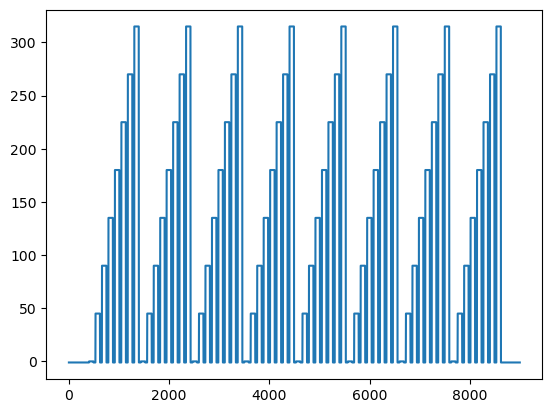

(374, 9000) (374, 9000) (374, 2) (374, 9000) (128,)
The number of detected cells is 118
The number of increments is 8
The angle increment is 45 degree


In [17]:
direc = "/Users/dannylim/Desktop/SampleData_/230214/LA24_1/suite2p/plane0" #"../cleanD"
fps = 30

f, fneu, iscell, spks, zeroC, cellFneu, original_ind, orient_dict, orientations, angles = OrientationTuning(direc, fps)

print(f.shape, fneu.shape, iscell.shape, spks.shape, zeroC.shape)
print("The number of detected cells is",(iscell==1).sum())
print("The number of increments is", int(zeroC.shape[0]/2/8))
print("The angle increment is", int(360/(zeroC.shape[0]/2/8)),"degree")

In [3]:
for c in range(17,19):#cellFneu.shape[0]):
    CelldataProcess(c, activitytrace=True, resultplot=True, OriActiplot=True, DataFitplot=True, SpikeFitplot=True)

NameError: name 'cellFneu' is not defined